In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import timm
import sys 
from torchinfo import summary
from scipy import signal
import pyVHR as vhr
import pickle
from typing import Optional
import math
import os

import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms


from TorchLossComputer import TorchLossComputer
from TorchLossComputerCPU import TorchLossComputerCPU
from PhysFormer import ViT_ST_ST_Compact3_TDC_gra_sharp


2022-06-29 16:39:42.552919: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
PATCH_SIZE = 16
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 12
BLOCKS = 12
BATCH = 300
LENGTH = 160

vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'

dataset_name = 'pure'           
video_DIR = '/var/datasets/VHR1/'  
BVP_DIR = '/var/datasets/VHR1/'    

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

/var/datasets/VHR1/PURE


In [4]:
def chunks(lst, bvp, stride = 5, window = 160):
    tmp = []
    tmp_bvp = []
    for i in range(0, len(lst)-window, stride):
        tmp.append(torch.as_tensor(lst[i:i + window]))
        tmp_bvp.append(torch.as_tensor(bvp[i:i + window]))
    if tmp[-1].shape[0] != tmp[0].shape[0]:
        return(torch.stack(tmp[:-1]),torch.stack(tmp_bvp[:-1]))
    return(torch.stack(tmp),torch.stack(tmp_bvp))
        
#webs,train_bvp = chunks(webs,train_bvp,160)

In [5]:
def load_data(tot):
    min_len = 0
    train_video = []
    train_bvp = []
    val_video = []
    val_bvp = []
    test_video = []
    test_bvp = []
    for idx in range(0,tot):
        with open('/var/datasets/PURE_webs/'+str(idx)+'-WEBS-'+str(PATCH_SIZE), 'rb') as f:
            #print('/var/datasets/PURE_webs/'+str(idx)+'-WEBS-'+str(PATCH_SIZE))
            (webs,labels) = pickle.load(f)
            if idx < ((tot/10)*9)-1:   #9 : 0 : 1
                train_video.append(webs)
                train_bvp.append(labels)
            #elif idx < (tot/10)*8+(tot/10):
                #print(2)
                #val_video.append(webs)
                #val_bvp.append(labels)
            else:
                #print(3)
                test_video.append(webs)
                test_bvp.append(labels)
            if min_len==0 or len(webs)<min_len:
                min_len = len(webs)
    for i in range(0,len(train_video)):
        train_video[i],train_bvp[i] = chunks(train_video[i][:min_len-1], train_bvp[i][:min_len-1])
    #for i in range(0,len(val_video)):
    #    val_video[i],val_bvp[i] = chunks(val_video[i][:min_len-1], val_bvp[i][:min_len-1],160)
    for i in range(0,len(test_video)):
        test_video[i],test_bvp[i] = chunks(test_video[i][:min_len-1], test_bvp[i][:min_len-1])
    return (train_video, train_bvp), (val_video, val_bvp), (test_video, test_bvp)


In [6]:
def save_ckp(model, optimizer, epoch, loss, iteration, path="."):
    checkpoint = {
        'epoch': epoch + 1,
        'iteration': iteration + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': loss
    }
    f_path = path + '/checkpoint.pt'
    torch.save(checkpoint, f_path)
    

In [7]:
def load_ckp(model, optimizer, path='./checkpoint.pt'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch'], checkpoint['iteration']

In [8]:
class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; i>0, 1- loss                                                                      
    def __init__(self):                                                           
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # all variable operation    
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])
            sum_y = torch.sum(labels[i])
            sum_xy = torch.sum(preds[i]*labels[i])
            sum_x2 = torch.sum(torch.pow(preds[i],2))
            sum_y2 = torch.sum(torch.pow(labels[i],2))
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))))
            loss += 1 - pearson
        loss = loss/preds.shape[0]
        return loss

In [9]:
class AvgrageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = (self.sum / self.cnt).item()

In [10]:
(train_video,train_bvp),(val_video,val_bvp),(test_video,test_bvp) = load_data(7)

In [11]:
train_video, train_bvp = torch.cat(train_video[:]), torch.cat(train_bvp[:])
#val_video, val_bvp     = torch.cat(val_video[:]), torch.cat(val_bvp[:])
test_video, test_bvp   = torch.cat(test_video[:]), torch.cat(test_bvp[:])



In [1]:
clazz = {}
for frame in train_bvp:
    for bvp in video:
        if bvp.item() in clazz: clazz[bvp.item()] += 1
        else: clazz[bvp.item()] = 1
            
print(clazz)

NameError: name 'train_bvp' is not defined

In [35]:
for k in sorted(clazz.keys()):
    print(str(k) + ": "+ str(clazz[k]))

-1: 21
0: 670
1: 213
2: 256
3: 96
4: 64
5: 353
6: 289
7: 430
8: 576
9: 717
10: 670
11: 1024
12: 1081
13: 1560
14: 2013
15: 2292
16: 2634
17: 3997
18: 4838
19: 5072
20: 6595
21: 7415
22: 9295
23: 9360
24: 10748
25: 11607
26: 11641
27: 11426
28: 9766
29: 8935
30: 8583
31: 7304
32: 6731
33: 7013
34: 5638
35: 4866
36: 4570
37: 4851
38: 5083
39: 5412
40: 5959
41: 4886
42: 5016
43: 5656
44: 5690
45: 5346
46: 6411
47: 6137
48: 6317
49: 5990
50: 6213
51: 6188
52: 5783
53: 4529
54: 5161
55: 5327
56: 4718
57: 4161
58: 3298
59: 3437
60: 3711
61: 3895
62: 3670
63: 3215
64: 2887
65: 3694
66: 2581
67: 2211
68: 2830
69: 2218
70: 1794
71: 2519
72: 1733
73: 1454
74: 1485
75: 1123
76: 1087
77: 1113
78: 845
79: 809
80: 725
81: 856
82: 511
83: 683
84: 480
85: 448
86: 432
87: 292
88: 388
89: 111
90: 217
91: 153
92: 103
93: 32
94: 103
96: 64
97: 160
99: 32
100: 32
104: 32
105: 64


In [12]:
BATCH = 4
#train_video = train_video.permute(0,4,1,2,3)
#val_video = val_video.permute(0,4,1,2,3)
#test_video = test_video.permute(0,4,1,2,3)
print(train_video.shape,train_bvp.shape)
dataset = torch.utils.data.TensorDataset(train_video.permute(0,4,1,2,3),torch.as_tensor(train_bvp))
trainloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH, shuffle=True, num_workers=1)

model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
print(summary(model))

optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.L1Loss()
criterion_Pearson = Neg_Pearson() 

loss = 0.0
epochs = 25

torch.Size([2142, 160, 160, 160, 3]) torch.Size([2142, 160])
Layer (type:depth-idx)                                            Param #
ViT_ST_ST_Compact3_TDC_gra_sharp                                  --
├─Conv3d: 1-1                                                     26,214,560
├─Transformer_ST_TDC_gra_sharp: 1-2                               --
│    └─ModuleList: 2-1                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-1                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-2                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-3                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-4                           1,485,904
├─Transformer_ST_TDC_gra_sharp: 1-3                               --
│    └─ModuleList: 2-2                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-5                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-6                        

In [14]:
def train(model, optimizer, trainloader, epoch_start=0, iter_start=0):
    criterion_reg = nn.MSELoss()
    criterion_L1loss = nn.L1Loss()
    criterion_class = nn.CrossEntropyLoss()
    criterion_Pearson = Neg_Pearson()
        
    a_start = 0.1
    b_start = 1.0
    exp_a = 0.5
    exp_b = 5.0
    
    writer = SummaryWriter()
    
    path_log = 'LOG'
    isExists = os.path.exists(path_log)
    if not isExists:
        os.makedirs(path_log)
    log_file = open(path_log+'/LOG_log.txt', 'w')
    
    for epoch in range(epoch_start, epochs):
        print("\nStarting epoch", epoch+1)
        loss = 0.0
        loss_rPPG_avg = AvgrageMeter()
        loss_peak_avg = AvgrageMeter()
        loss_kl_avg_test = AvgrageMeter()
        loss_bvp_mae = AvgrageMeter()
        
        model.train()
        for i, data in enumerate(trainloader,0):
            if i >= iter_start: 
                
                iter_start = 0
                inputs, targets = data
                inputs, targets = inputs.float().cuda(), targets.float().cuda()
                
                optimizer.zero_grad()
                rPPG = model(inputs,0.2) 
                rPPG = (rPPG-torch.mean(rPPG)) /torch.std(rPPG)
                #loss
                loss = criterion_reg
                loss_rPPG = criterion_Pearson(rPPG, targets)
                fre_loss = 0.0
                kl_loss = 0.0
                train_mae = 0.0
                for bb in range(inputs.shape[0]):
                    loss_distribution_kl, fre_loss_temp, train_mae_temp = TorchLossComputer.cross_entropy_power_spectrum_DLDL_softmax2(
                        rPPG[bb], torch.mean(targets[bb].float()), 30, std=1.0) 
                    fre_loss = fre_loss + fre_loss_temp
                    kl_loss = kl_loss + loss_distribution_kl
                    train_mae = train_mae + train_mae_temp
                fre_loss = fre_loss/inputs.shape[0]
                kl_loss = kl_loss/inputs.shape[0]
                train_mae = train_mae/inputs.shape[0]
                print(train_mae)
                if epoch >25:
                    a = 0.05
                    b = 5.0
                else:
                    a = a_start*math.pow(exp_a, epoch/25.0)
                    b = b_start*math.pow(exp_b, epoch/25.0)
            
                a = 0.1
            
                loss =  a*loss_rPPG + b*(fre_loss+kl_loss)
                
                loss.backward()
                optimizer.step()
                
                n = inputs.size(0)
                loss_rPPG_avg.update(loss_rPPG.data, n)
                loss_peak_avg.update(fre_loss.data, n)
                loss_kl_avg_test.update(kl_loss.data, n)
                loss_bvp_mae.update(train_mae, n)
                
                print("\n")
                sys.stdout.write('\r')
                sys.stdout.write(f"Iteration {i+1}, loss= {loss/((i+1)*inputs.shape[0]):1.5f}, NegPearson= {loss_rPPG_avg.avg:1.5f}, kl= {loss_kl_avg_test.avg:1.5f}, fre_CEloss= {loss_peak_avg.avg:1.5f}")
                sys.stdout.flush()
                
                writer.add_scalar('Epoch '+str(epoch)+' Loss/train', loss/((i+1)*inputs.shape[0]), i)

                save_ckp(model, optimizer, loss, epoch, i)
                
                if( i%50 == 0):
                    log_file.write("\n")        
                    log_file.write(f"Epoch {epoch+1}, Iteration {i+1}, loss= {loss/((i+1)*inputs.shape[0]):1.5f}, NegPearson= {loss_rPPG_avg.avg:1.5f}, kl= {loss_kl_avg_test.avg:1.5f}, fre_CEloss= {loss_peak_avg.avg:1.5f}")
                    log_file.write("\n")
                    log_file.write("\n")
                    log_file.flush()
                

    return model, loss, loss_rPPG_avg, loss_peak_avg, loss_kl_avg_test, loss_bvp_mae



In [15]:
model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
model = model.cuda()
model.train() 
print("iterations per epoch: ",len(trainloader)) 
print("epochs: {0}\nStart".format(epochs)) 
train(model,optimizer,trainloader, 0,0) 
print('\nTraining process has finished.')

iterations per epoch:  536
epochs: 25
Start

Starting epoch 1


RuntimeError: CUDA out of memory. Tried to allocate 1.22 GiB (GPU 0; 31.75 GiB total capacity; 5.84 GiB already allocated; 747.69 MiB free; 5.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

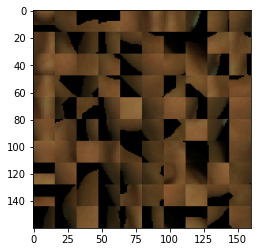

1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
4
4
4
4
4
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
4
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
1
1
1
1
1
1
1
1
1
1
1
1
5
6
6
6
6
5
6
6
6
6
6
6
7
7
7
7
7
10
10
10
13
13
13
13
17
21
21
21
21
21
21
21
24
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
18
13
12
12
12
12
12
12
8
5
5
5
5
5
5
5
1
1
1
1
1
1
1
3
8
9
9
9
9
9
9
10
13
13
13
13
13
13
13
15
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
19
14
15
15
15
15
15
15
17
19
23
23
23
23
23
23
21
16
17


In [32]:
#for t in range(0,train_bvp.size(0)): print(t,torch.min(train_bvp[t]),torch.max(train_bvp[t]))
train_bvp[1317][19]
plt.imshow(train_video[1317][19].numpy())
plt.show()
for t in train_bvp:
    c=0
    for f in t:
        if f==0:
            c+=1
    print(c)

In [15]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import numpy as np

writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

In [14]:
#LOAD MODEL

epochs = 5
model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
optimizer = torch.optim.Adam(model.parameters())
model, optimizer, epoch, iteration = load_ckp(model,optimizer,'./checkpoint.pt.bk')
#train(model,optimizer, trainloader, epoch, iteration)

In [19]:

#train_video = train_video.permute(0,4,1,2,3)
#val_video = val_video.permute(0,4,1,2,3)
#test_video = test_video.permute(0,4,1,2,3)
print(train_video.shape,train_bvp.shape)
dataset = torch.utils.data.TensorDataset(test_video.permute(0,4,1,2,3),torch.as_tensor(test_bvp))
testloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=1)

model = ViT_ST_ST_Compact3_TDC_gra_sharp(image_size=(160,160,160), patches=(4,16,16), dim=160, ff_dim=144, num_heads=4, num_layers=12, dropout_rate=0.1, theta=0.7)
print(summary(model))
model, optimizer, epoch, iteration = load_ckp(model,optimizer,'./checkpoint.pt.bk')

optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.L1Loss()
criterion_Pearson = Neg_Pearson() 

loss = 0.0
epochs = 5



torch.Size([2142, 160, 160, 160, 3]) torch.Size([2142, 160])
Layer (type:depth-idx)                                            Param #
ViT_ST_ST_Compact3_TDC_gra_sharp                                  --
├─Conv3d: 1-1                                                     26,214,560
├─Transformer_ST_TDC_gra_sharp: 1-2                               --
│    └─ModuleList: 2-1                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-1                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-2                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-3                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-4                           1,485,904
├─Transformer_ST_TDC_gra_sharp: 1-3                               --
│    └─ModuleList: 2-2                                            --
│    │    └─Block_ST_TDC_gra_sharp: 3-5                           1,485,904
│    │    └─Block_ST_TDC_gra_sharp: 3-6                        

In [32]:
writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [31]:
with open('epoch_loss.sv', 'rb') as f:
    loss = pickle.load(f)

In [20]:
with torch.no_grad(): 
    for data in testloader: 
        inputs, targets = data 
        inputs, targets = inputs.float(), targets.float()
        predicted_outputs = model(inputs,0.2) 
        print(predicted_outputs[0][0])
        print(targets[0][0])

        #_, predicted = torch.max(predicted_outputs, 1) 
        #total += outputs.size(0) 
        #running_accuracy += (predicted == outputs).sum().item() 

    #print('Accuracy of the model based on the test set of', test_split ,'inputs is: %d %%' % (100 * running_accuracy / total))    


tensor(-0.0025)
tensor(23.)
tensor(-0.0467)
tensor(75.)


KeyboardInterrupt: 

In [31]:
#train_bvp = signal.resample(sigGT.data, len(webs))
print(webs.shape,torch.as_tensor(train_bvp).shape)
dataset = torch.utils.data.TensorDataset(webs,torch.as_tensor(train_bvp))
trainloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=1)



torch.Size([1947, 150, 150, 3]) torch.Size([1947])


In [40]:
model.eval()
accuracy = 0.0
total = 0.0
    
with torch.no_grad():
    for i, data in enumerate(trainloader, 1):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        err = torch.abs(torch.mean(outputs,1)- targets).item()
        total = i
        accuracy += err
        sys.stdout.write('\r')
        sys.stdout.write(f"Iteration {i}, Accuracy: {accuracy/total:1.5f} {outputs}")
        sys.stdout.flush()

print(accuracy)

Iteration 1, Accuracy: 12.54637 tensor([[33.3883, 33.4594, 33.4671, 33.4381, 33.4450, 33.4685, 33.4702, 33.4694,
         33.4371, 33.4689, 33.4699, 33.4692, 33.4323, 33.4369, 33.4478, 33.4447,
         33.4683, 33.4036, 33.4307, 33.4642, 33.4683, 33.4700, 33.4674, 33.4713,
         33.4649, 33.4346, 33.4710, 33.4680, 33.4678, 33.4389, 33.4655, 33.4705,
         33.4475, 33.4087, 33.4680, 33.4308, 33.4707, 33.4556, 33.4609, 33.4681,
         33.4681, 33.4705, 33.4030, 33.4583, 33.4490, 33.4658, 33.4659, 33.4619,
         33.4395, 33.4692, 33.4637, 33.4693, 33.4654, 33.4597, 33.4446, 33.4483,
         33.4561, 33.4448, 33.4606, 33.4654, 33.4650, 33.4665, 33.4690, 33.4684,
         33.4694, 33.4434, 33.4625, 33.4686, 33.4012, 33.4627, 33.4681, 33.4530,
         33.4712, 33.4235, 33.4270, 33.4539, 33.4641, 33.4694, 33.4646, 33.4666,
         33.4708, 33.4479, 33.4219, 33.4604, 33.4122, 33.4586, 33.4699, 33.4640,
         33.4649, 33.4517, 33.4699, 33.4114, 33.4297, 33.4703, 33.4051, 33.45

Iteration 10, Accuracy: 10.00970 tensor([[33.3880, 33.4579, 33.4712, 33.4433, 33.4493, 33.4668, 33.4711, 33.4700,
         33.4380, 33.4699, 33.4699, 33.4709, 33.4562, 33.4529, 33.4627, 33.4500,
         33.4693, 33.4144, 33.4277, 33.4664, 33.4658, 33.4694, 33.4635, 33.4710,
         33.4688, 33.4449, 33.4672, 33.4692, 33.4690, 33.4421, 33.4637, 33.4702,
         33.4532, 33.4336, 33.4661, 33.4445, 33.4680, 33.4531, 33.4589, 33.4690,
         33.4656, 33.4706, 33.4259, 33.4615, 33.4615, 33.4657, 33.4710, 33.4622,
         33.4458, 33.4659, 33.4637, 33.4667, 33.4648, 33.4369, 33.4268, 33.4468,
         33.4712, 33.4418, 33.4616, 33.4595, 33.4659, 33.4637, 33.4683, 33.4646,
         33.4700, 33.4471, 33.4716, 33.4692, 33.4014, 33.4415, 33.4687, 33.4523,
         33.4687, 33.4293, 33.4551, 33.4703, 33.4709, 33.4697, 33.4592, 33.4674,
         33.4708, 33.4496, 33.4225, 33.4689, 33.4429, 33.4621, 33.4691, 33.4646,
         33.4675, 33.4510, 33.4693, 33.4184, 33.4271, 33.4679, 33.4394, 33.4

Iteration 19, Accuracy: 11.08145 tensor([[33.3883, 33.4600, 33.4668, 33.4368, 33.4472, 33.4688, 33.4706, 33.4698,
         33.4361, 33.4688, 33.4698, 33.4693, 33.4288, 33.4394, 33.4488, 33.4424,
         33.4704, 33.4016, 33.4211, 33.4651, 33.4682, 33.4699, 33.4673, 33.4714,
         33.4655, 33.4373, 33.4708, 33.4681, 33.4684, 33.4391, 33.4654, 33.4706,
         33.4490, 33.4119, 33.4674, 33.4295, 33.4704, 33.4548, 33.4609, 33.4684,
         33.4678, 33.4698, 33.4045, 33.4609, 33.4508, 33.4660, 33.4688, 33.4620,
         33.4392, 33.4698, 33.4640, 33.4685, 33.4651, 33.4614, 33.4528, 33.4468,
         33.4563, 33.4532, 33.4615, 33.4662, 33.4649, 33.4657, 33.4691, 33.4688,
         33.4695, 33.4463, 33.4647, 33.4688, 33.3958, 33.4599, 33.4682, 33.4507,
         33.4712, 33.4259, 33.4269, 33.4589, 33.4661, 33.4694, 33.4612, 33.4668,
         33.4708, 33.4482, 33.4244, 33.4611, 33.4185, 33.4594, 33.4702, 33.4637,
         33.4658, 33.4497, 33.4700, 33.4172, 33.4383, 33.4703, 33.4057, 33.4

Iteration 28, Accuracy: 9.57150 tensor([[33.3883, 33.4585, 33.4694, 33.4388, 33.4482, 33.4685, 33.4711, 33.4697,
         33.4345, 33.4695, 33.4700, 33.4702, 33.4387, 33.4435, 33.4528, 33.4452,
         33.4684, 33.4049, 33.4216, 33.4652, 33.4677, 33.4693, 33.4665, 33.4715,
         33.4692, 33.4386, 33.4700, 33.4683, 33.4689, 33.4396, 33.4658, 33.4701,
         33.4511, 33.4181, 33.4688, 33.4292, 33.4698, 33.4545, 33.4595, 33.4691,
         33.4676, 33.4704, 33.4109, 33.4614, 33.4542, 33.4660, 33.4706, 33.4608,
         33.4393, 33.4688, 33.4635, 33.4673, 33.4654, 33.4559, 33.4444, 33.4462,
         33.4623, 33.4480, 33.4612, 33.4644, 33.4646, 33.4647, 33.4685, 33.4677,
         33.4696, 33.4419, 33.4677, 33.4687, 33.3965, 33.4572, 33.4683, 33.4505,
         33.4708, 33.4274, 33.4316, 33.4623, 33.4700, 33.4695, 33.4574, 33.4657,
         33.4707, 33.4452, 33.4222, 33.4652, 33.4168, 33.4614, 33.4701, 33.4643,
         33.4664, 33.4483, 33.4697, 33.4175, 33.4264, 33.4696, 33.4135, 33.46

Iteration 37, Accuracy: 10.96311 tensor([[33.3881, 33.4531, 33.4712, 33.4433, 33.4497, 33.4667, 33.4710, 33.4701,
         33.4371, 33.4700, 33.4700, 33.4708, 33.4556, 33.4563, 33.4631, 33.4449,
         33.4694, 33.4122, 33.4206, 33.4665, 33.4674, 33.4691, 33.4637, 33.4709,
         33.4692, 33.4415, 33.4679, 33.4698, 33.4689, 33.4401, 33.4659, 33.4704,
         33.4523, 33.4351, 33.4660, 33.4443, 33.4682, 33.4515, 33.4600, 33.4688,
         33.4677, 33.4702, 33.4233, 33.4617, 33.4625, 33.4646, 33.4713, 33.4624,
         33.4438, 33.4636, 33.4647, 33.4670, 33.4666, 33.4395, 33.4260, 33.4490,
         33.4705, 33.4476, 33.4618, 33.4543, 33.4661, 33.4635, 33.4685, 33.4652,
         33.4701, 33.4465, 33.4714, 33.4696, 33.4001, 33.4437, 33.4692, 33.4524,
         33.4691, 33.4293, 33.4520, 33.4696, 33.4711, 33.4694, 33.4575, 33.4681,
         33.4709, 33.4498, 33.4237, 33.4691, 33.4364, 33.4634, 33.4699, 33.4653,
         33.4667, 33.4489, 33.4702, 33.4159, 33.4232, 33.4675, 33.4384, 33.4

KeyboardInterrupt: 

In [2]:
PATCH_SIZE = 15
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 5
BLOCKS = 12

class PatchEmbed(nn.Module):
  def __init__(self, img_size, patch_size, in_chans=3, embed_dim=EMBED_DIM):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size) ** 2
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = torch.movedim(x,3,1)
    x = self.proj(x)       # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
    x = x.flatten(2)        # (n_samples, embed_dim, n_patches)
    x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

    return x

class Attention(nn.Module):


  def __init__(self, dim, n_heads=HEADS, qkv_bias=True, attn_p=0., proj_p=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    n_samples, n_tokens, dim = x.shape

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
    qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches + 1, head_dim)

    # compute att matrices
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)   # (n_samples, n_heads, head_dim, n_patches + 1)
    dp = (q @ k_t) * self.scale

    attn = dp.softmax(dim=-1)   # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)

    # compute weigthed avg
    weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

    # linear projection
    x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
    x = self.proj_drop(x)        # (n_samples, n_patches + 1, dim)

    return x

class MLP(nn.Module):

    def __init__(self, in_features, hidden_features, out_features, p=0.):
      super().__init__()
      self.fc1 = nn.Linear(in_features, hidden_features)
      self.act = nn.GELU()
      self.fc2 = nn.Linear(hidden_features, out_features)
      self.drop = nn.Dropout(p)

    def forward(self, x):
      x = self.fc1(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.act(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
      x = self.fc2(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

      return x

class Block(nn.Module):
    
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
      super().__init__()
      self.norm1 = nn.LayerNorm(dim, eps=1e-6)
      self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
      self.norm2 = nn.LayerNorm(dim, eps=1e-6)
      hidden_features = int(dim * mlp_ratio)
      self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)

    def forward(self, x):
     
      
      x = x + self.attn(self.norm1(x))
      x = x + self.mlp(self.norm2(x))

      return x

class VisionTransformer(nn.Module):
  
  def __init__(
          self,
          img_size=IMG_SIZE,
          patch_size=PATCH_SIZE,
          in_chans=3,
          n_classes=1000,
          embed_dim=EMBED_DIM,
          depth=BLOCKS,
          n_heads=HEADS,
          mlp_ratio=4.,
          qkv_bias=True,
          p=0.,
          attn_p=0.,
  ):
    super().__init__()

    self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
    )
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)

    self.blocks = nn.ModuleList(
        [
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            )
            for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)
    self.lastConv = nn.Conv1d(embed_dim, 1,1,stride=1, padding=0)
    
  def forward(self, x):
    n_samples = x.shape[0]
    x = self.patch_embed(x)  #(n_samples, n_patches, embed_dim)
    
    
    cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
    #x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
    x = self.pos_drop(x)

    for block in self.blocks:
      x = block(x)

    x = self.norm(x)

    cls_token_final = x[:, 0]  # just the CLS token
    #x = self.head(cls_token_final)
    #x = x.type(torch.DoubleTensor)
    #x = torch.mean(x,1)
    #x = torch.mean(x,1)
    x = x.permute(0, 2, 1) 
    x = self.lastConv(x)
    x = x.squeeze(1)
    
    return x
